## Forecast HSR score

#### Import packages

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SUPERVISED LEARNING IMPORT
# scikit-learn imports
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
# imbalanced-learn imports
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# neural net import
from sklearn.neural_network import MLPClassifier

# UNSUPERVISED LEARNING
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage

## 1. Data preparation and feature engineering 

In [3]:
# Load dataset (adjust path if needed)
try:
    df = pd.read_csv('dataset/INDICATORS.csv')
except:
    df = pd.read_csv('INDICATORS.csv')

In [4]:
# Rename target and columns
if 'label success' in df.columns:
    df = df.rename(columns={'label success': 'success'})
df.columns = df.columns.str.strip()
df = df.rename(columns = {
    'gdp_growth_rate (billions of us dollars)': 'gdp_growth',
    'gdp (percent change)': 'gdp_total',
    'gdp_per_capita (us dollar per capita)':       'gdp_pc',
    'rail lines (total route-km)':                 'rail_km',
    'hsr_network_length':                          'hsr_km',
    'total_population (thousands)':                'pop_thousands',
    'population_density (people/square kilometer)': 'pop_density',
    'urbanization_rate':                           'urban_rate',
    'passenger demand (million)': 'pas_demand'
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_id     21 non-null     object 
 1   gdp_growth     21 non-null     float64
 2   gdp_total      21 non-null     float64
 3   gdp_pc         21 non-null     int64  
 4   rail_km        21 non-null     int64  
 5   hsr_km         21 non-null     int64  
 6   pop_thousands  21 non-null     float64
 7   pop_density    21 non-null     int64  
 8   urban_rate     21 non-null     float64
 9   ROI            21 non-null     float64
 10  pas_demand     21 non-null     float64
 11  success        21 non-null     int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 2.1+ KB


In [5]:
# If needed, convert numeric strings
# df['rail_km'] = df['rail_km'].astype(str).str.replace(',', '', regex=False).astype(float)
# df['hsr_km']      = pd.to_numeric(df['hsr_km'], errors='coerce')
# df['gdp_growth']  = pd.to_numeric(df['gdp_growth'], errors='coerce')
# df['urban_rate']  = pd.to_numeric(df['urban_rate'], errors='coerce')


## 2. Feature engineering

In [6]:
df['hsr_per_thousand'] = df['hsr_km'] / df['pop_thousands']
df['rail_per_thousand'] = df['rail_km'] / df['pop_thousands']
df['hsr_share'] = df['hsr_km'] / df['rail_km']
df['gdp_pc_urban_interaction'] = df['gdp_pc'] * df['urban_rate']
df['density_growth_interaction'] = df['pop_density'] * df['gdp_growth']

## SUPERVISED LEARNING

### 3. Define X and y

In [7]:
features = [
    'gdp_growth', 'gdp_total', 'gdp_pc',
    'pop_density', 'urban_rate',
    'hsr_per_thousand', 'rail_per_thousand',
    'hsr_share', 'gdp_pc_urban_interaction',
    'density_growth_interaction'
]

X = df[features]
y = df['success']


### 4. Pipelines and LOO-CV comparision

In [8]:
loo = LeaveOneOut()

pipe_lr = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear',
                               class_weight= 'balanced', max_iter = 1000))
])

pipe_smote_lr = ImbPipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('smote', SMOTE(k_neighbors=3, random_state=0)),
    ('clf', LogisticRegression(penalty='l1', solver='liblinear',
                               max_iter=1000))
])

pipe_svm = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', SVC(kernel='rbf', class_weight='balanced', probability= True))
])

pipe_rf = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=4,
                                   class_weight='balanced', random_state=42))
])

voting = VotingClassifier(estimators=[
    ('lr', pipe_smote_lr),
    ('svm', pipe_svm),
    ('rf', pipe_rf)
], voting='soft')

models = [
    ('Logistic', pipe_lr),
    ('SMOTE+Logistic', pipe_smote_lr),
    ('SVM (RBF)', pipe_svm),
    ('RandomForest', pipe_rf),
    ('VotingEnsemble', voting)
]

In [9]:
print('Model Comparison via Leave-One-Out CV:')
for name, model in models:
    scores = cross_val_score(model, X, y, cv=loo, scoring='accuracy', n_jobs = -1)
    print(f"{name:15s}: {scores.mean():.2f} ± {scores.std():.2f}")

Model Comparison via Leave-One-Out CV:
Logistic       : 0.57 ± 0.49
SMOTE+Logistic : 0.57 ± 0.49
SVM (RBF)      : 0.52 ± 0.50
RandomForest   : 0.33 ± 0.47
VotingEnsemble : 0.48 ± 0.50


### 5. Grid search hyperparameter tuning

#### a. Elastic-Net Logistic

In [10]:
pipe_enet = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(
        penalty= 'elasticnet', solver ='saga',
        class_weight='balanced', max_iter=5000))
])

param_grid_enet = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
}

gs_enet = GridSearchCV(
    pipe_enet, param_grid_enet,
    cv=loo, scoring= 'accuracy', n_jobs=-1
)

gs_enet.fit(X, y)
print("Elastic-Net Best Params:", gs_enet.best_params_)
print("Elastic-Net LOO-cv Acc:", gs_enet.best_score_)

Elastic-Net Best Params: {'clf__C': 0.01, 'clf__l1_ratio': 0.75}
Elastic-Net LOO-cv Acc: 0.6666666666666666


In [42]:
pipe_log_gs = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),
    ('clf',    LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000))
])

param_grid_log = {
    'clf__C':        [0.01, 0.1, 1, 10, 100],
}

gs_log = GridSearchCV(
    pipe_log_gs,
    param_grid_log,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
gs_log.fit(X, y)

print("Logistic Best Params:", gs_log.best_params_)
print("Logistic 5-Fold Acc  :", gs_log.best_score_)

Logistic Best Params: {'clf__C': 0.01}
Logistic 5-Fold Acc  : 0.52


#### b. SVM Grid

In [18]:
pipe_svm_gs = Pipeline([
    ('impute', SimpleImputer()),
    ('scale', StandardScaler()),
    ('clf', SVC(class_weight='balanced', probability=True))
])

param_grid_svm = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.1, 1]
}

gs_svm = GridSearchCV(pipe_svm_gs, param_grid_svm, 
                      cv=5, scoring='accuracy', n_jobs=-1)
gs_svm.fit(X,y)
print("SVM Best Params:", gs_svm.best_params_)
print("SVM 5-Fold CV Acc:", gs_svm.best_score_)

SVM Best Params: {'clf__C': 1, 'clf__gamma': 1}
SVM 5-Fold CV Acc: 0.54


In [38]:
pipe_svm = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler()),
    ('clf',    SVC(class_weight='balanced', probability=True))
])

param_grid = {
  'clf__C':     [0.1, 1, 10],
  'clf__gamma': ['scale', 0.01, 0.1, 1]
}

grid_svm = GridSearchCV(pipe_svm, param_grid, cv=LeaveOneOut(), scoring='accuracy')
grid_svm.fit(X, y)
print("SVM Best Params:", grid_svm.best_params_)
print("SVM Leave One Out CV Acc:", grid_svm.best_score_)

SVM Best Params: {'clf__C': 0.1, 'clf__gamma': 0.01}
SVM Leave One Out CV Acc: 0.9047619047619048


#### c. Random Forest grid

In [12]:
pipe_rf_gs = Pipeline([
    ('impute', SimpleImputer()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=0))
])

param_grid_rf = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [2, 4, 5, None],
    'clf__min_samples_leaf': [1, 2, 4]
}

gs_rf = GridSearchCV(pipe_rf_gs, param_grid_rf, cv=5,
                     scoring='accuracy', n_jobs=-1)
gs_rf.fit(X,y)
print("RF Best Params:", gs_rf.best_params_)
print("RF 5-Fold CV Acc:", gs_rf.best_score_)

RF Best Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 50}
RF 5-Fold CV Acc: 0.63


In [41]:
pipe_rf_gs = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('clf',    RandomForestClassifier(class_weight='balanced', random_state=0))
])

param_grid_rf = {
    'clf__n_estimators':    [50, 100, 200],
    'clf__max_depth':       [2, 4, 6, None],
    'clf__min_samples_leaf':[1, 2, 4]
}

gs_rf = GridSearchCV(
    pipe_rf_gs,
    param_grid_rf,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1
)
gs_rf.fit(X, y)

print("RF Best Params:", gs_rf.best_params_)
print("RF LOOCV Acc  :", gs_rf.best_score_)

RF Best Params: {'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__n_estimators': 50}
RF LOOCV Acc  : 0.47619047619047616


#### d. Nested Loo Comparision for tuned models

In [13]:
tuned = [
    ('ElasticNet-LR', gs_enet),
    ('SVM', gs_svm),
    ('RandomForest', gs_rf)
]

print("Nested Loo-CV (Tuned Models):")
for name, gs in tuned:
    nested_scores = cross_val_score(gs, X, y, cv=LeaveOneOut(), n_jobs=-1)
    print(f"{name:15s}: {nested_scores.mean():.2f} ± {nested_scores.std():.2f}")

Nested Loo-CV (Tuned Models):
ElasticNet-LR  : 0.48 ± 0.50
SVM            : 0.57 ± 0.49
RandomForest   : 0.57 ± 0.49


### 5.5 Feature selection with RFECV

#### a. Logistic Regression

In [34]:
# run RFECV to pick the best subset of features
selector = RFECV(
    estimator= LogisticRegression(
        penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000
    ),
    cv = LeaveOneOut(),
    scoring = 'accuracy',
    min_features_to_select= 3,
    n_jobs=-1
)
selector.fit(X, y)

print(f"Optimal # features: {selector.n_features_}")
print("Selected features:", list(X.columns[selector.support_]))

Optimal # features: 3
Selected features: ['gdp_growth', 'rail_per_thousand', 'density_growth_interaction']


In [35]:
# reduce X to only those selected features
X_reduced = X.loc[:, selector.support_]

# re-run best tuned model on the reduced feature set with nested LOO
print("Nested LOO-CV on reduced Feature Set:")
for name, gs in tuned: # tuned is the list of GridSearchCV models
    scores = cross_val_score(gs, X_reduced, y, cv=LeaveOneOut(), n_jobs=-1)
    print(f'{name:15s}: {scores.mean():.2f} ± {scores.std():.2f}')

Nested LOO-CV on reduced Feature Set:
ElasticNet-LR  : 0.43 ± 0.49
SVM            : 0.57 ± 0.49
RandomForest   : 0.43 ± 0.49


#### b. SVM

In [36]:
selector_svm = RFECV(
    estimator=SVC(kernel='linear', class_weight='balanced'),
    cv=LeaveOneOut(),
    scoring='accuracy',
    min_features_to_select=3,
    n_jobs=-1
)
selector_svm.fit(X, y)
print(f"SVM - Optimal # features: {selector_svm.n_features_}")
print("SVM - Selected features:", list(X.columns[selector_svm.support_]))

# Reduce X for SVM
X_svm_reduced = X.loc[:, selector_svm.support_]

# Nested LOO-CV for tuned SVM on reduced set
svm_scores_reduced = cross_val_score(gs_svm, X_svm_reduced, y, cv=LeaveOneOut(), n_jobs=-1)
print(f"SVM (tuned) on reduced features: {svm_scores_reduced.mean():.2f} ± {svm_scores_reduced.std():.2f}")


SVM - Optimal # features: 6
SVM - Selected features: ['gdp_growth', 'urban_rate', 'hsr_per_thousand', 'rail_per_thousand', 'hsr_share', 'density_growth_interaction']
SVM (tuned) on reduced features: 0.67 ± 0.47


#### c. Random Forest

In [37]:
selector_rf = RFECV(
    estimator=RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    cv=LeaveOneOut(),
    scoring='accuracy',
    min_features_to_select=3,
    n_jobs=-1
)
selector_rf.fit(X, y)
print(f"RF - Optimal # features: {selector_rf.n_features_}")
print("RF - Selected features:", list(X.columns[selector_rf.support_]))

# Reduce X for RF
X_rf_reduced = X.loc[:, selector_rf.support_]

# Nested LOO-CV for tuned RF on reduced set
rf_scores_reduced = cross_val_score(gs_rf, X_rf_reduced, y, cv=LeaveOneOut(), n_jobs=-1)
print(f"RandomForest (tuned) on reduced features: {rf_scores_reduced.mean():.2f} ± {rf_scores_reduced.std():.2f}")


RF - Optimal # features: 5
RF - Selected features: ['gdp_growth', 'gdp_total', 'pop_density', 'gdp_pc_urban_interaction', 'density_growth_interaction']
RandomForest (tuned) on reduced features: 0.57 ± 0.49


### 6. Epoch-based learning and plotting

In [26]:
#  split a small train/val set for epoch-based curves
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size = 0.2, stratify= y, random_state = 42
)

#### a) SGDCClassifier (logistic via SGD)

In [28]:
sgd_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('clf', SGDClassifier(loss='log_loss', max_iter=1, tol=None,
                          learning_rate='optimal',
                          warm_start=True, random_state=0))
])

n_epochs = 50
train_acc_sgd = []
val_acc_sgd = []

for epoch in range(n_epochs):
    sgd_pipe.fit(X_tr, y_tr)
    train_acc_sgd.append(sgd_pipe.score(X_tr, y_tr))
    val_acc_sgd.append(sgd_pipe.score(X_val, y_val))

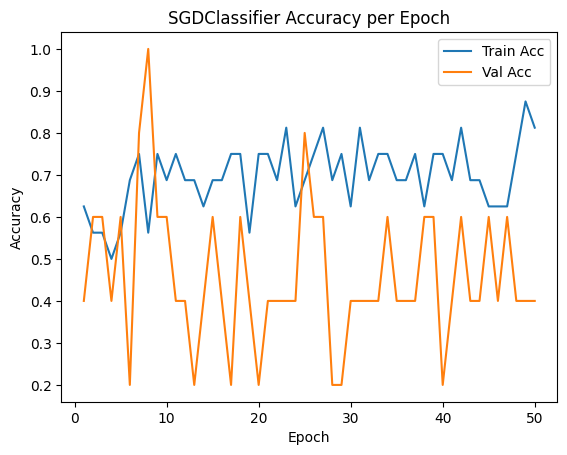

In [31]:
plt.figure()
plt.plot(range(1, n_epochs+1), train_acc_sgd, label='Train Acc')
plt.plot(range(1, n_epochs+1), val_acc_sgd, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('SGDClassifier Accuracy per Epoch')
plt.legend()
plt.show()

#### b) MLPClassifier (Neural Net)

In [30]:
mlp = MLPClassifier(hidden_layer_sizes=(16,), max_iter = 200,
                    early_stopping= True, validation_fraction=0.1,
                    n_iter_no_change=10, random_state=0)
mlp.fit(X_tr, y_tr)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(16,), random_state=0)

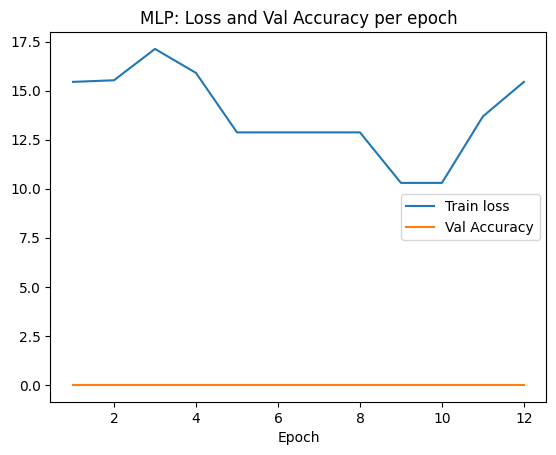

In [32]:
epochs = list(range(1, len(mlp.loss_curve_)+1))
plt.figure()
plt.plot(epochs, mlp.loss_curve_, label = 'Train loss')
plt.plot(epochs, mlp.validation_scores_, label='Val Accuracy')
plt.xlabel('Epoch')
plt.title('MLP: Loss and Val Accuracy per epoch')
plt.legend()
plt.show()

## UNSUPERVISED LEARNING

### 7. Impute and scale

In [45]:
imputer = SimpleImputer(strategy='median')
scaler = RobustScaler()

In [46]:
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

### 8. Dimensionality Reduction

#### a. PCA

In [48]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

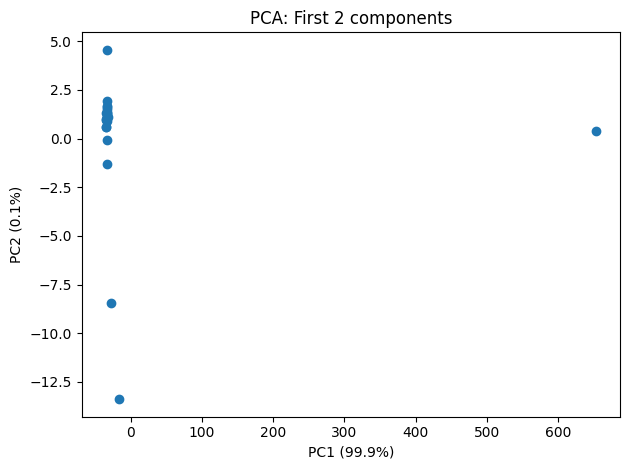

In [50]:
plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('PCA: First 2 components')
plt.xlabel('PC1 (%.1f%%)' % (100*pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 (%.1f%%)' % (100*pca.explained_variance_ratio_[1]))
plt.tight_layout()
plt.show()

#### b. t-SNE

In [52]:
tsne = TSNE(n_components=2, perplexity=10, random_state=0, n_jobs=1)
X_tsne = tsne.fit_transform(X_scaled)

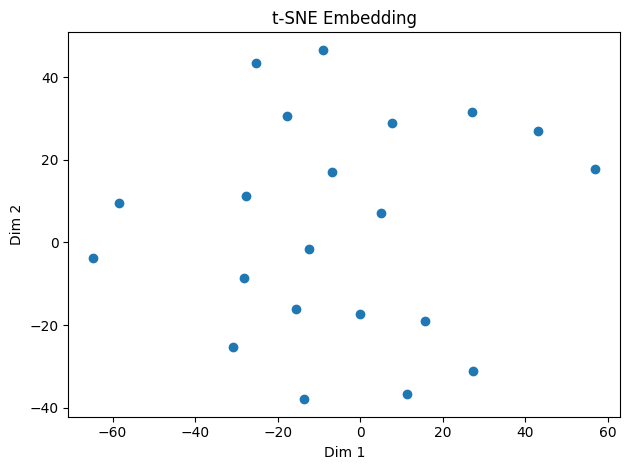

In [53]:
plt.figure()
plt.scatter(X_tsne[:,0], X_tsne[:,1])
plt.title('t-SNE Embedding')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.tight_layout()
plt.show()

### 9. Clustering and Validation

In [54]:
def evaluate_clustering(estimator, X_data, name):
    labels = estimator.fit_predict(X_data)
    sil = silhouette_score(X_data, labels)
    ch = calinski_harabasz_score(X_data, labels)
    db = davies_bouldin_score(X_data, labels)
    print(f"{name:20s} | Clusters: {len(np.unique(labels))} | Sil: {sil:.2f} | CH: {ch:.1f} | DB: {db:.2f}")
    return labels

#### a. K-means

In [59]:
for k in range(2,21):
    km = KMeans(n_clusters=k, random_state=0)
    evaluate_clustering(km, X_scaled, f"KMeans K = {k}")

KMeans K = 2         | Clusters: 2 | Sil: 0.94 | CH: 9948.9 | DB: 0.01
KMeans K = 3         | Clusters: 3 | Sil: 0.67 | CH: 10101.7 | DB: 0.11
KMeans K = 4         | Clusters: 4 | Sil: 0.49 | CH: 10140.3 | DB: 0.39
KMeans K = 5         | Clusters: 5 | Sil: 0.53 | CH: 15391.3 | DB: 0.34
KMeans K = 6         | Clusters: 6 | Sil: 0.44 | CH: 14844.3 | DB: 0.18
KMeans K = 7         | Clusters: 7 | Sil: 0.16 | CH: 16383.3 | DB: 0.52
KMeans K = 8         | Clusters: 8 | Sil: 0.14 | CH: 15273.4 | DB: 0.49
KMeans K = 9         | Clusters: 9 | Sil: 0.14 | CH: 15089.7 | DB: 0.52
KMeans K = 10        | Clusters: 10 | Sil: 0.11 | CH: 14338.6 | DB: 0.52
KMeans K = 11        | Clusters: 11 | Sil: 0.19 | CH: 19756.8 | DB: 0.47
KMeans K = 12        | Clusters: 12 | Sil: 0.15 | CH: 18959.9 | DB: 0.49
KMeans K = 13        | Clusters: 13 | Sil: 0.10 | CH: 17314.5 | DB: 0.49
KMeans K = 14        | Clusters: 14 | Sil: 0.09 | CH: 19251.5 | DB: 0.46
KMeans K = 15        | Clusters: 15 | Sil: 0.07 | CH: 18627.

"Elbow" on inertia

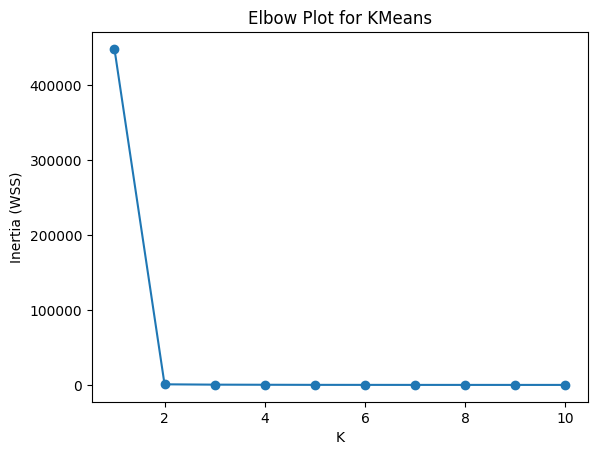

In [74]:
inertias = []
Ks = range(1, 11)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(Ks, inertias, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia (WSS)')
plt.title('Elbow Plot for KMeans')
plt.show()

#### b. Gaussian Mixture

In [60]:
for k in range(2,21):
    gm = GaussianMixture(n_components=k, random_state=0)
    labels = gm.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    print(f"{'GMM K='+str(k):20s} | Sil: {sil:.2f}")

GMM K=2              | Sil: 0.94
GMM K=3              | Sil: 0.67
GMM K=4              | Sil: 0.49
GMM K=5              | Sil: 0.53
GMM K=6              | Sil: 0.44
GMM K=7              | Sil: 0.16
GMM K=8              | Sil: 0.14
GMM K=9              | Sil: 0.14
GMM K=10             | Sil: 0.11
GMM K=11             | Sil: 0.19
GMM K=12             | Sil: 0.15
GMM K=13             | Sil: 0.10
GMM K=14             | Sil: 0.09
GMM K=15             | Sil: 0.07
GMM K=16             | Sil: 0.10
GMM K=17             | Sil: 0.08
GMM K=18             | Sil: 0.06
GMM K=19             | Sil: 0.03
GMM K=20             | Sil: 0.02


#### C. Agglomerative

In [61]:
for k in range(2,21):
    ag = AgglomerativeClustering(n_clusters=k)
    evaluate_clustering(ag, X_scaled, f"Agglomerative K = {k}")

Agglomerative K = 2  | Clusters: 2 | Sil: 0.94 | CH: 9948.9 | DB: 0.01
Agglomerative K = 3  | Clusters: 3 | Sil: 0.65 | CH: 11463.7 | DB: 0.39
Agglomerative K = 4  | Clusters: 4 | Sil: 0.54 | CH: 12387.2 | DB: 0.46
Agglomerative K = 5  | Clusters: 5 | Sil: 0.53 | CH: 15391.3 | DB: 0.34
Agglomerative K = 6  | Clusters: 6 | Sil: 0.20 | CH: 15085.9 | DB: 0.63
Agglomerative K = 7  | Clusters: 7 | Sil: 0.18 | CH: 16539.1 | DB: 0.49
Agglomerative K = 8  | Clusters: 8 | Sil: 0.18 | CH: 18592.4 | DB: 0.53
Agglomerative K = 9  | Clusters: 9 | Sil: 0.19 | CH: 19018.4 | DB: 0.54
Agglomerative K = 10 | Clusters: 10 | Sil: 0.19 | CH: 19092.8 | DB: 0.51
Agglomerative K = 11 | Clusters: 11 | Sil: 0.19 | CH: 19756.8 | DB: 0.47
Agglomerative K = 12 | Clusters: 12 | Sil: 0.17 | CH: 20412.8 | DB: 0.44
Agglomerative K = 13 | Clusters: 13 | Sil: 0.14 | CH: 20925.8 | DB: 0.49
Agglomerative K = 14 | Clusters: 14 | Sil: 0.14 | CH: 21816.5 | DB: 0.41
Agglomerative K = 15 | Clusters: 15 | Sil: 0.12 | CH: 23218.

#### d. DBSCAN

In [65]:
for eps in [0.5, 1.0]:
    db = DBSCAN(eps=eps, min_samples=3)
    labels = db.fit_predict(X_scaled)
    # ignore all noise case
    if len(np.unique(labels))>1:
        sil = silhouette_score(X_scaled, labels)
        print(f"{'DBSCAN eps='+str(eps):20s} | Sil: {sil:.2f}")

#### e. Hierachical dendogram

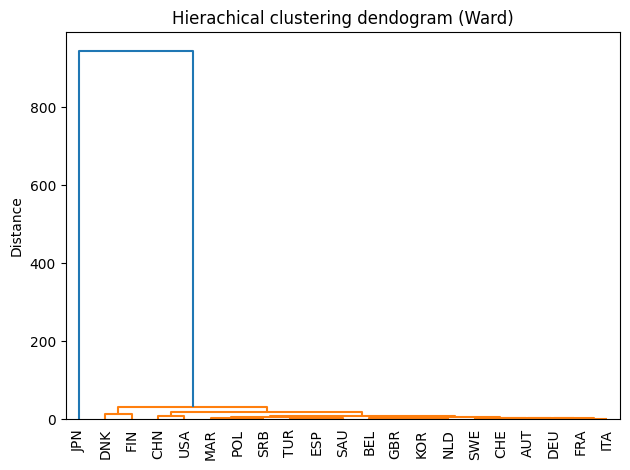

In [72]:
linked = linkage(X_scaled, method = 'ward')
plt.figure()
dendrogram(linked, labels = df['country_id'].tolist(), leaf_rotation=90)
plt.title('Hierachical clustering dendogram (Ward)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

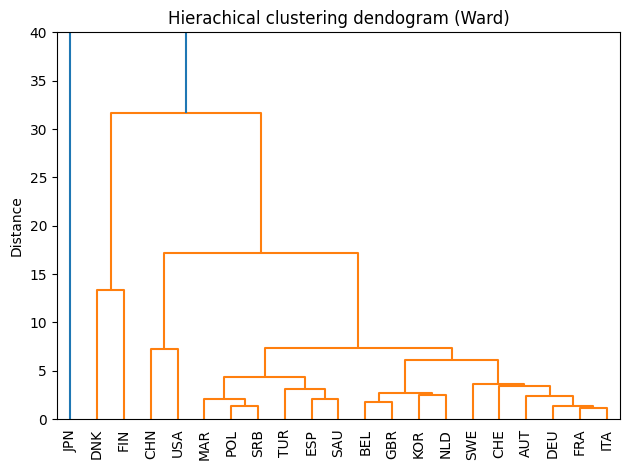

In [73]:
linked = linkage(X_scaled, method = 'ward')
plt.figure()
dendrogram(linked, labels = df['country_id'].tolist(), leaf_rotation=90)
plt.title('Hierachical clustering dendogram (Ward)')
plt.ylabel('Distance')
plt.ylim(0,40)
plt.tight_layout()
plt.show()

### 10. Clustering profiling

In [84]:
# Chose best K for Kmeans
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X_scaled)
df['cluster_kmeans']= kmeans.labels_

# profile clusters by mean feature values
profile = df.groupby('cluster_kmeans')[features].mean()
print('Cluster profiles (means):')
print(profile)

Cluster profiles (means):
                gdp_growth    gdp_total        gdp_pc  pop_density  \
cluster_kmeans                                                       
0                 1.857895  3989.735789  46787.894737   183.052632   
1                 0.600000  4190.000000  33960.000000   343.000000   
2                 1.000000   303.950000  54160.000000    18.000000   

                urban_rate  hsr_per_thousand  rail_per_thousand  hsr_share  \
cluster_kmeans                                                               
0                 0.775789          0.055975           0.332717   0.199086   
1                 0.920000         23.699004         161.315451   0.146911   
2                 0.860000          1.061264           1.059831   1.001352   

                gdp_pc_urban_interaction  density_growth_interaction  
cluster_kmeans                                                        
0                           37722.215789                  258.657895  
1                  

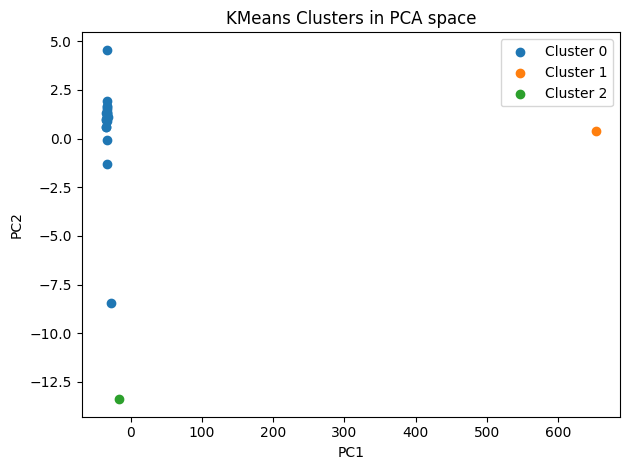

In [85]:
# Visualize cluster in PCA space
plt.figure()
for c in sorted(df['cluster_kmeans'].unique()):
    mask = df['cluster_kmeans']==c
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f"Cluster {c}")
plt.legend()
plt.title('KMeans Clusters in PCA space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()